# MAKING DATASET

In [1]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define the dataset path inside Google Drive
dataset_dir = "/content/drive/MyDrive/facial_recognition_dataset"

# Create the folder if it doesn’t exist
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)

print(f"Dataset is stored at: {dataset_dir}")


Mounted at /content/drive
Dataset is stored at: /content/drive/MyDrive/facial_recognition_dataset


In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import os

# Function to take a photo
def take_photo(person_name, photo_count, quality=0.8):
    from IPython.display import display, Javascript
    from google.colab.output import eval_js
    from base64 import b64decode

    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])

    # Define path in Google Drive
    person_folder = os.path.join(dataset_dir, person_name)
    if not os.path.exists(person_folder):
        os.makedirs(person_folder)

    filename = os.path.join(person_folder, f"{person_name}_{photo_count}.jpg")

    # Save photo
    with open(filename, 'wb') as f:
        f.write(binary)

    print(f"✅ Photo saved at: {filename}")
    print(f"🗂 Check folder: {person_folder}")

    return filename


# Function to create a folder for a person
def create_person_folder(person_name):
    folder_name = f"dataset/{person_name}"
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    return folder_name

# Function to validate the dataset (ensure each label has at least one image)
def validate_dataset(dataset_dir):
    # List all folders, but skip hidden folders (those starting with a dot)
    class_names = sorted([f for f in os.listdir(dataset_dir) if not f.startswith('.')])

    for person_name in class_names:
        person_folder = os.path.join(dataset_dir, person_name)

        # Skip if it's not a directory (just to be sure)
        if not os.path.isdir(person_folder):
            continue

        # Check if there are image files in the folder
        image_files = [f for f in os.listdir(person_folder) if f.lower().endswith(('png', 'jpg', 'jpeg'))]

        if len(image_files) == 0:
            print(f"Warning: {person_name} has no valid image files.")
        else:
            print(f"{person_name} has {len(image_files)} images.")



# Main function to capture labeled photos
def capture_labeled_photos():
    while True:
        person_name = input("Enter the person's name (or 'q' to quit): ").strip()
        if person_name.lower() == 'q':
            print("Exiting...")
            break

        print(f"Capturing photos for {person_name}. Press 'Capture' to take a photo.")

        photo_count = 0
        while True:
            take_photo(person_name, photo_count)
            photo_count += 1

            another = input("Capture another photo? (y/n): ").strip().lower()
            if another != 'y':
                print(f"Finished capturing photos for {person_name}.")
                break

# Run the function to start taking photos
capture_labeled_photos()

# After capturing photos, validate the dataset
validate_dataset(dataset_dir)

Enter the person's name (or 'q' to quit): q
Exiting...
arshia has 8 images.
aruv has 2 images.
harshita has 6 images.
kashish has 12 images.
ritigya has 14 images.


# TRAIN AND TEST

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

dataset_dir = "/content/drive/MyDrive/facial_recognition_dataset"

# List folders (skip hidden folders like .ipynb_checkpoints)
class_names = sorted([f for f in os.listdir(dataset_dir) if not f.startswith('.')])

# Print the class names (person names) to ensure they are in the correct order
print("Class names (labels):", class_names)

# Initialize lists to store images and labels
# Initialize lists to store images and labels
images = []
labels = []

# Loop through each person's folder and load images
for label, person_name in enumerate(class_names):
    person_folder = os.path.join(dataset_dir, person_name)

    if os.path.isdir(person_folder):
        # Sort the images in the folder to ensure correct order
        image_files = sorted([f for f in os.listdir(person_folder) if f.lower().endswith(('png', 'jpg', 'jpeg'))])

        if len(image_files) > 0:
            for image_name in image_files:
                image_path = os.path.join(person_folder, image_name)
                # Load the image and resize it (e.g., 128x128)
                image = load_img(image_path, target_size=(128, 128))
                image = img_to_array(image) / 255.0  # Normalize pixel values to [0, 1]
                images.append(image)
                labels.append(label)
        else:
            print(f"Warning: {person_name} has no valid image files.")
    else:
        print(f"Warning: {person_name} is not a valid directory or is empty.")

# Convert lists to NumPy arrays
images = np.array(images)
labels = np.array(labels)

# Verify label-image alignment after loading the dataset
for i in range(5):  # Checking first 5 images and their labels
    print(f"Image {i}: Label = {labels[i]} -> {class_names[labels[i]]}")


# Perform a stratified split to ensure all classes are represented in both training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels
)

# After splitting, print a few label-name pairs from the training set
for i in range(5):  # Checking first 5 images and their labels
    print(f"Training image {i}: Label = {train_labels[i]}, Name = {class_names[train_labels[i]]}")

# Print shapes of the datasets
print("Training images shape:", train_images.shape)
print("Training labels shape:", train_labels.shape)
print("Testing images shape:", test_images.shape)
print("Testing labels shape:", test_labels.shape)

Class names (labels): ['arshia', 'aruv', 'harshita', 'kashish', 'ritigya']
Image 0: Label = 0 -> arshia
Image 1: Label = 0 -> arshia
Image 2: Label = 0 -> arshia
Image 3: Label = 0 -> arshia
Image 4: Label = 0 -> arshia
Training image 0: Label = 2, Name = harshita
Training image 1: Label = 1, Name = aruv
Training image 2: Label = 0, Name = arshia
Training image 3: Label = 4, Name = ritigya
Training image 4: Label = 0, Name = arshia
Training images shape: (33, 128, 128, 3)
Training labels shape: (33,)
Testing images shape: (9, 128, 128, 3)
Testing labels shape: (9,)


In [ ]:
# import matplotlib.pyplot as plt

# # Display an image from the training dataset
# plt.figure()
# plt.imshow(train_images[1])  # RGB images do not need cmap='gray'
# plt.colorbar()
# plt.grid(False)
# plt.show()


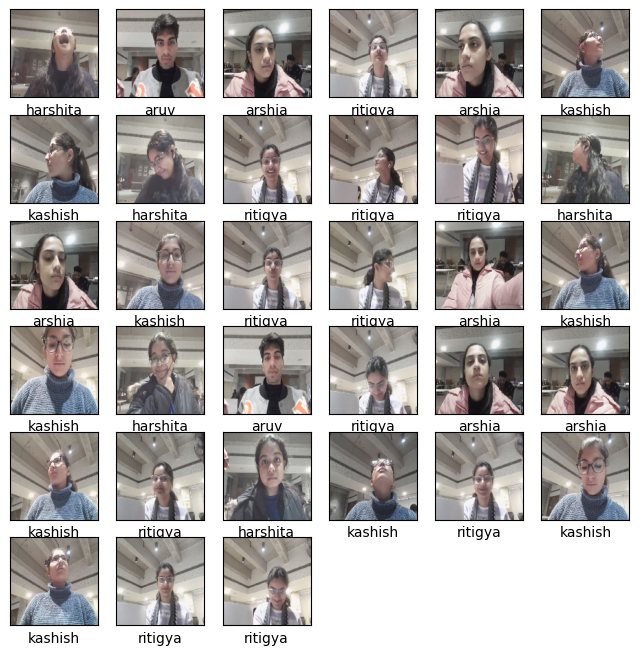

In [ ]:
import matplotlib.pyplot as plt

num_images = len(train_images)  # Get the number of available images

plt.figure(figsize=(8, 8))  # Adjust figure size
for i in range(num_images):  # Loop through only existing images
    plt.subplot(6,6, i + 1)  # Create a 2x2 grid (since you have 4 images)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])  # Display the image
    plt.xlabel(class_names[train_labels[i]])  # Show person's name

plt.show()



In [ ]:
import tensorflow as tf
from tensorflow import keras

# model = keras.Sequential([
#     keras.layers.Flatten(input_shape=(128, 128, 3)),  # Flatten 128x128 RGB images into a 1D vector
#     keras.layers.Dense(128, activation='relu'),  # Hidden layer with 128 neurons
#     keras.layers.Dense(len(class_names), activation='softmax')  # Output layer (number of classes = number of people)
# ])

model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(len(class_names), activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(train_images, train_labels, epochs=20, validation_split=0.2)


Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.0769 - loss: 1.6251 - val_accuracy: 0.4286 - val_loss: 1.3173
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.3077 - loss: 1.7194 - val_accuracy: 0.4286 - val_loss: 1.7035
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3462 - loss: 1.6458 - val_accuracy: 0.4286 - val_loss: 1.6281
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4615 - loss: 1.4916 - val_accuracy: 0.5714 - val_loss: 1.4676
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8462 - loss: 1.3568 - val_accuracy: 0.4286 - val_loss: 1.1467
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5000 - loss: 1.2016 - val_accuracy: 0.8571 - val_loss: 0.9653
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 804ms/step - accuracy: 0.7692 - loss: 1.0779 - val_accuracy: 0.8571 - val_loss: 0.8858
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step - accuracy: 0.9231 - loss: 0.8426 - val_accuracy: 0.5714 - val_loss: 0.7888
Epoch 9/20

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=1)

print('Test accuracy:', test_acc)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.8889 - loss: 0.5385
Test accuracy: 0.8888888955116272


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array

# Function to capture a photo
def take_photo(filename='captured_photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            // Wait for Capture to be clicked.
            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    print(f"Photo saved as {filename}")
    return filename


# PREDICT

<IPython.core.display.Javascript object>

Photo saved as captured_photo.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted probabilities: [[4.5643433e-04 8.3442387e-07 3.7450911e-05 1.8899689e-03 9.9761534e-01]]


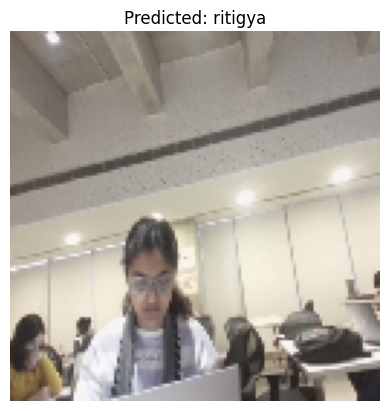

In [ ]:

# Function to preprocess the captured image
def preprocess_image(image_path):
    image = load_img(image_path, target_size=(128, 128))
    image = img_to_array(image) / 255.0
    return image


def predict_face(model, image, class_names):
    prediction = model.predict(np.array([image]))  # Shape: (1, num_classes)
    print("Predicted probabilities:", prediction)  # Check the raw predictions
    predicted_class_index = np.argmax(prediction)  # Get index of highest probability
    predicted_class = class_names[predicted_class_index]
    return predicted_class

# Function to display the result
def show_face(image, predicted_class):
    plt.figure()
    plt.imshow(image)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()

# Step 1: Capture a photo
captured_image_path = take_photo()

# Step 2: Preprocess the captured image
captured_image = preprocess_image(captured_image_path)

# Step 3: Predict the face
predicted_class = predict_face(model, captured_image, class_names)

# Step 4: Display the result
show_face(captured_image, predicted_class)